In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

%matplotlib inline

### The Model

$$\sigma \sim exp(50)$$
$$\nu \sim exp(.1)$$
$$s_i \sim N(s_{i-1},\sigma^{-2})$$
$$\log(y_i) \sim t(\nu, 0, exp(-2s_i))$$

In [6]:
import pandas as pd

returns = pd.read_csv('data/SP500.csv', index_col=0, parse_dates=True)
print(len(returns))

400


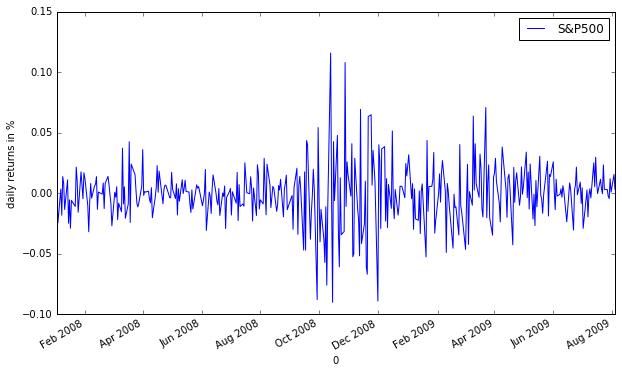

In [7]:
returns.plot(figsize=(10,6))
plt.ylabel('daily returns in %')

In [9]:
from pymc3 import Model
from pymc3 import Exponential, StudentT, exp, Deterministic
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns['S&P500'])

Applied log-transform to nu and added transformed nu_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.


In [13]:
from pymc3 import find_MAP, NUTS, sample
import theano
theano.config.blas.ldflags = ''
import scipy

with sp500_model:
    start = find_MAP(vars=[s], fmin=scipy.optimize.fmin_l_bfgs_b)
    
    step = NUTS(scaling=start)
    trace = sample(100, step, progressbar=False)
    
    # Start next run at the last sampled position
    step = NUTS(scaling=trace[-1], gamma=.25)
    trace = sample(2000, step, start=trace[-1], progressbar=False)

INFO (theano.gof.compilelock): Refreshing lock /Users/mjdillon/.theano/compiledir_Darwin-15.3.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir/lock


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a5c0160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c62c978>]], dtype=object)

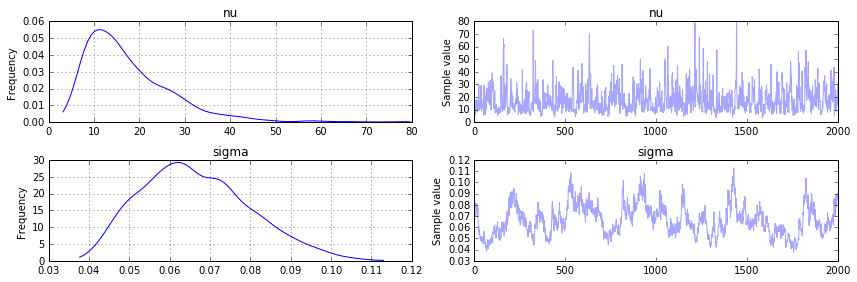

In [15]:
from pymc3 import traceplot
traceplot(trace, [nu, sigma])

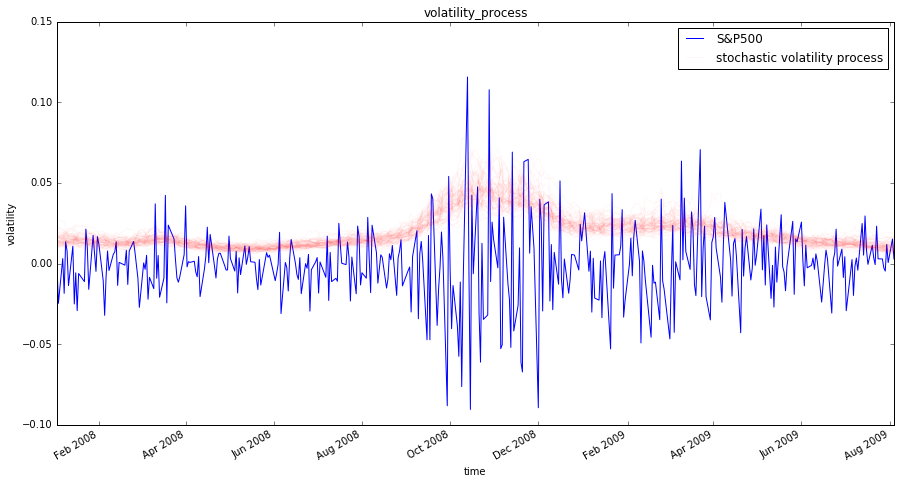

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::30].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])